# Make sweep do sweep.run()

In this notebook we goof around with the sweep to see if we can make it behave more like the old Loop.

We are after something like:
```

my_sweep = nest(sweep(instrument.p1, np.linspace(-4, 4, 100)), instrument.p2)
my_sweep.run()  # does the whole shebang

```

This is mainly just playing to get to know the new sweep module, but we will get requests for this functionality from Copenhagen users.

Here we just blindly add a Sweep class to the Sweep module. Full source code:

```python
class Sweep:
    """
    The class to replace the Loop

    For starters, it tries to be as similar to the Loop
    as possible, but with the sweep module behind it
    """

    def __init__(self, param_sweep: BaseSweepObject):
        """
        Args:
            param_sweep: the setpoint sweep
        """
        self._sweep = param_sweep
        self._run_id = None

    def run(self):
        """
        Run the measurement
        """

        sweep_obj = self._sweep

        measurement = SweepMeasurement()
        measurement.register_sweep(sweep_obj)

        with measurement.run() as datasaver:
            for data in sweep_obj:
                datasaver.add_result(*data.items())

        self._run_id = datasaver.run_id

    @property
    def run_id(self):
        return self._run_id

```

In [1]:
import numpy as np

import qcodes as qc
from qcodes.dataset.plotting import plot_by_id
from qcodes.sweep import sweep, nest, chain, SweepMeasurement, Sweep

## 1D

In [2]:
x = qc.Parameter('x', set_cmd=lambda x: None)
m = qc.Parameter('m', get_cmd=lambda : np.sin(x()))

### Original sweep style

Starting experimental run with id: 13


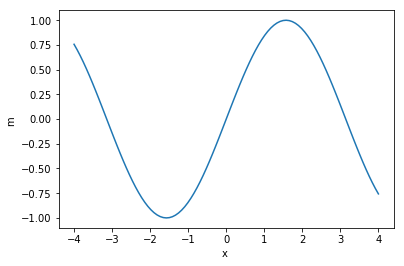

In [3]:
# sweep_object = nest(sweep(x, np.linspace(-4, 4, 100)), m)
sweep_object = sweep(x, np.linspace(-4, 4, 100))(m)

meas = SweepMeasurement()
meas.register_sweep(sweep_object)

with meas.run() as datasaver: 
    for data in sweep_object: 
        datasaver.add_result(*data.items())
    
    dataid = datasaver.run_id  # convenient to have for plotting
    
_ = plot_by_id(dataid)

### Proposed Loop nostalgia style

Starting experimental run with id: 14


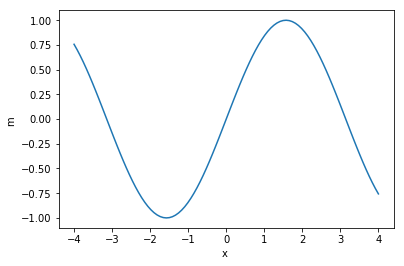

In [4]:
my_sweep = Sweep(sweep(x, np.linspace(-4, 4, 100))(m))
my_sweep.run()
_ = plot_by_id(dataid)

## 2D

In [5]:
x = qc.Parameter('x', set_cmd=lambda x: None)
y = qc.Parameter('y', set_cmd=lambda x: None)
m = qc.Parameter('m', get_cmd=lambda : np.sin(x()) + 2*np.cos(y()))

### Original sweep style

Starting experimental run with id: 15


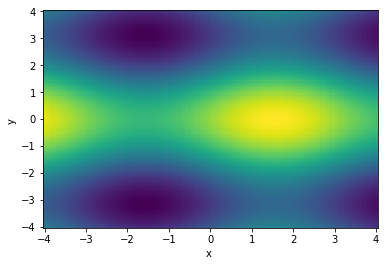

In [6]:
inner = sweep(y, np.linspace(-4, 4, 100))(m)
outer = sweep(x, np.linspace(-4, 4, 100))(inner)

meas = SweepMeasurement()
meas.register_sweep(outer)
with meas.run() as datasaver: 
    for data in outer: 
        datasaver.add_result(*data.items())
    
    dataid = datasaver.run_id
fig = plot_by_id(dataid)

### Proposed Loop nostalgia style

Starting experimental run with id: 18


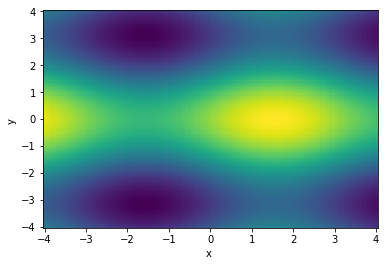

In [10]:
inner = sweep(y, np.linspace(-4, 4, 100))(m)
outer = Sweep(sweep(x, np.linspace(-4, 4, 100))(inner))
outer.run()
_ = plot_by_id(outer.run_id)


## Discussion

This is indeed one way to go, but it is not very cool, as seen by the surprising and non-intuitive syntax of the 2D example. 

### Million dollar question

How far up can we promote the `run` method and still have the sweep module be modularly independent from the dataset?
